# Results v4:

## General Hyperparameters:

- Dataset: MNIST (scaled down to 14x14)
- Model: 2-layer MLP (196-32-ReLU-10)
- Training batch size: 32
- Optimizer: SGD
- Learning rate: 0.001
- Epochs: 5

## GGN Hyperparameters:
- GGN batch sizes: $[2^i]_{i=0}^{12}$
- GGN computations after $n$ training steps: $n \in \{0, 4000, 8000\}$
- GGN samples per computation iteration: 8

In [37]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import LogFormatterExponent
from tueplots import bundles
import torch

plt.rcParams.update(bundles.beamer_moml())

## 0 - Profiling and Code Optimization

According to Prof. Hennig's suggestion, I profiled my code and found out that the actual realization of the GGN (the J_T H J product) is indeed the most expensive part, at least, when being conducted on the CPU. 
However, for 14x14 MNIST and 8 GGN samples, the memory of the used 1080 Ti GPU (10GB) is sufficient and speeds up computations drastically, s.t. a run with GGN computations including the exact GGN only takes 10-15 minutes.
For 28x28 MNIST, by contrast, there is no hope to perform these computations on the GPU, leading to runtimes in the order of several hours.

## 1 - Qualitative Investigation of Data Samples:

The last results revealed some interesting behavior for the "loss-inv" data sampling strategy (sampling lowest-loss datapoints with highest probability), with the Frobenius norm between the subsampled GGN and the exact GGN deceeding the corresponding F-norm when using uniform data sampling up to sample size 128.
Wondering how the sampled datapoints look like and whether there is some obvious structure apperent, the first 16x8 (note that 8 different GGNs are computed per sample size) sampled data points when using the "loss-inv" strategy at different training stages (0, 4000, 8000 steps, respectively) are depicted below. 
For direct comparison, the first 16x8 datapoints obtained by uniform sampling (where the training stage does not matter) are shown as well.

In [43]:
results_path = "../results/datapoints/"
sampling_methods = ["loss_inv", "uniform"]
steps = {3: 0, 2: 4000, 1: 8000}
num_batches = 16
num_samples = 8

C:\Users\fabri\AppData\Local\Temp\ipykernel_20020\3647949458.py:12: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.03, 1, 0.975])


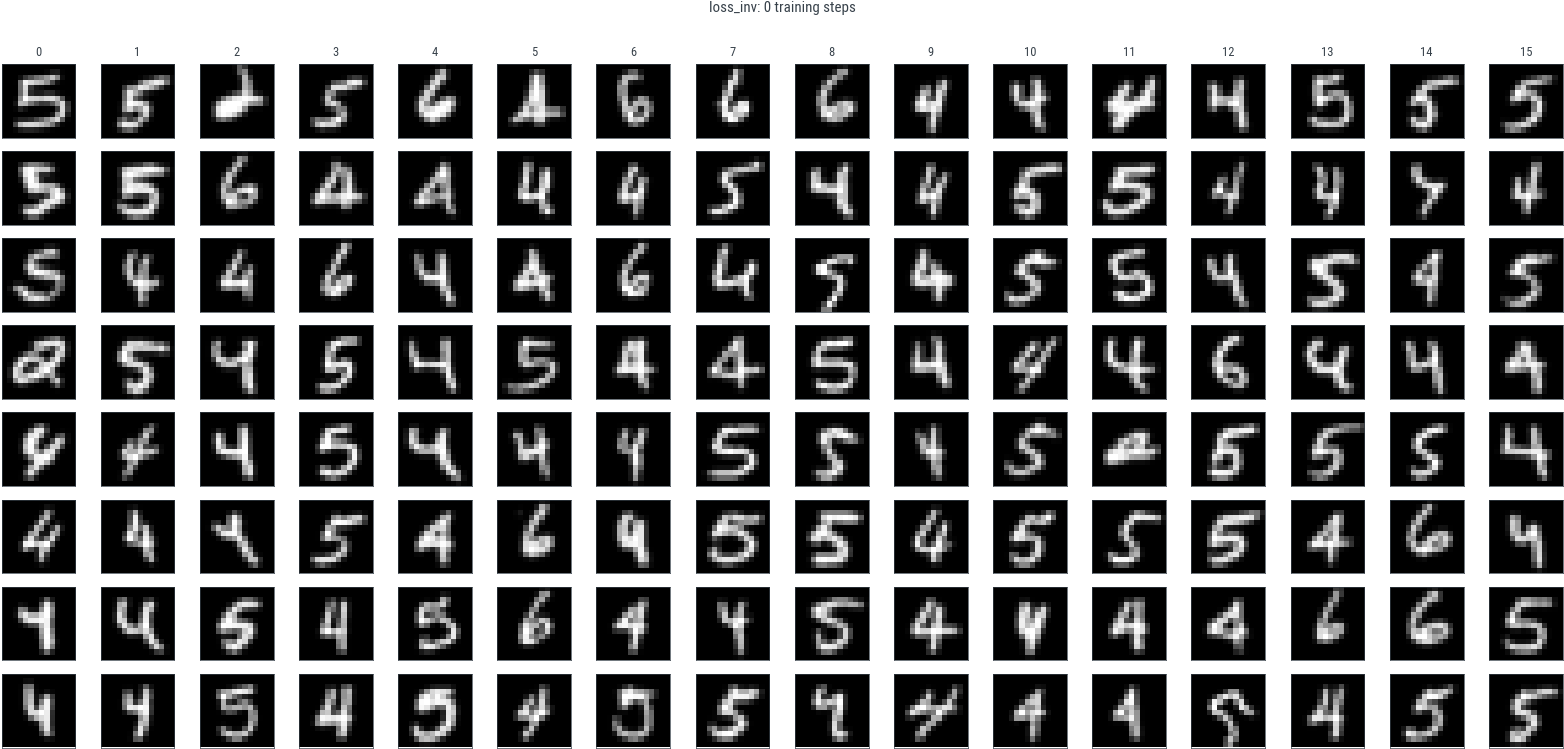

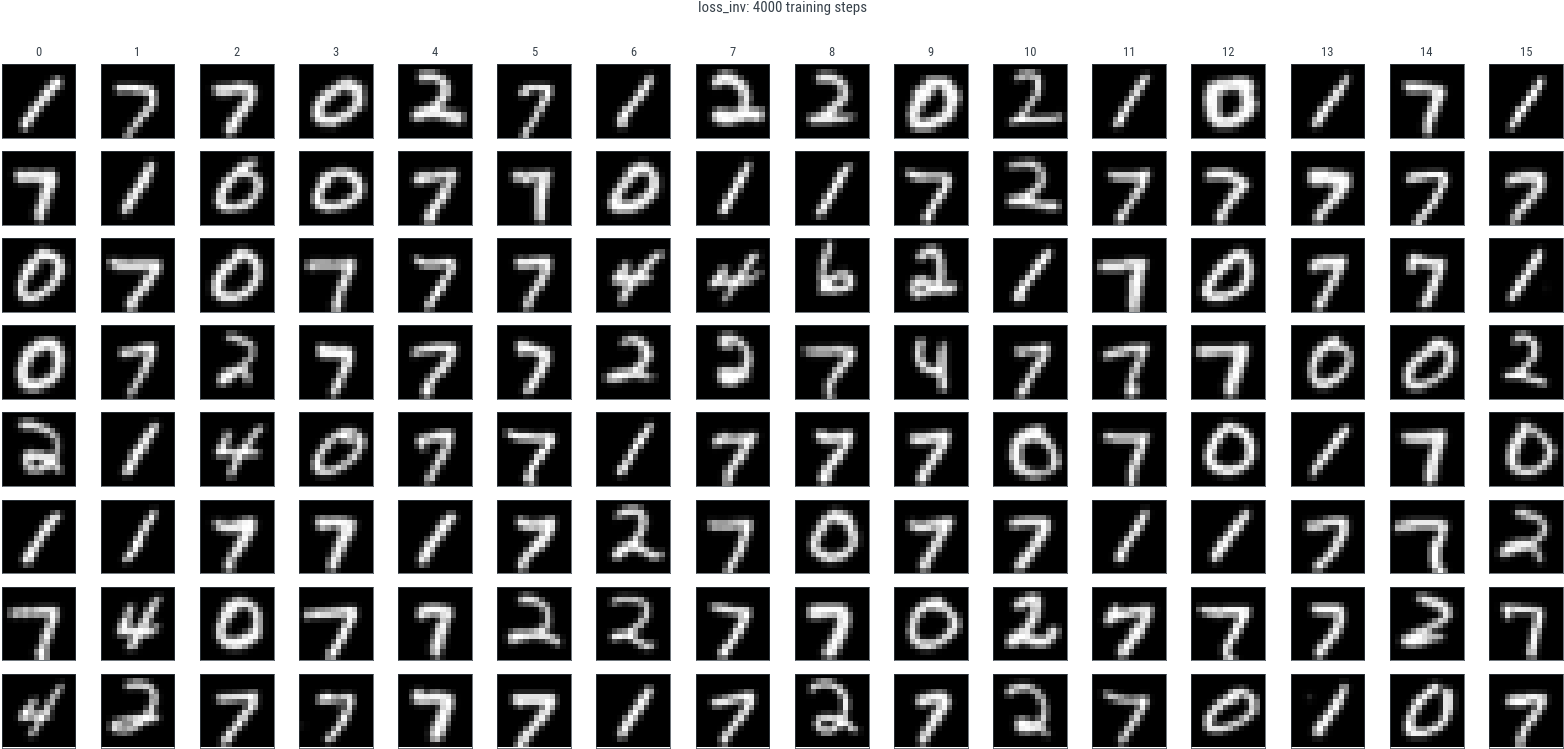

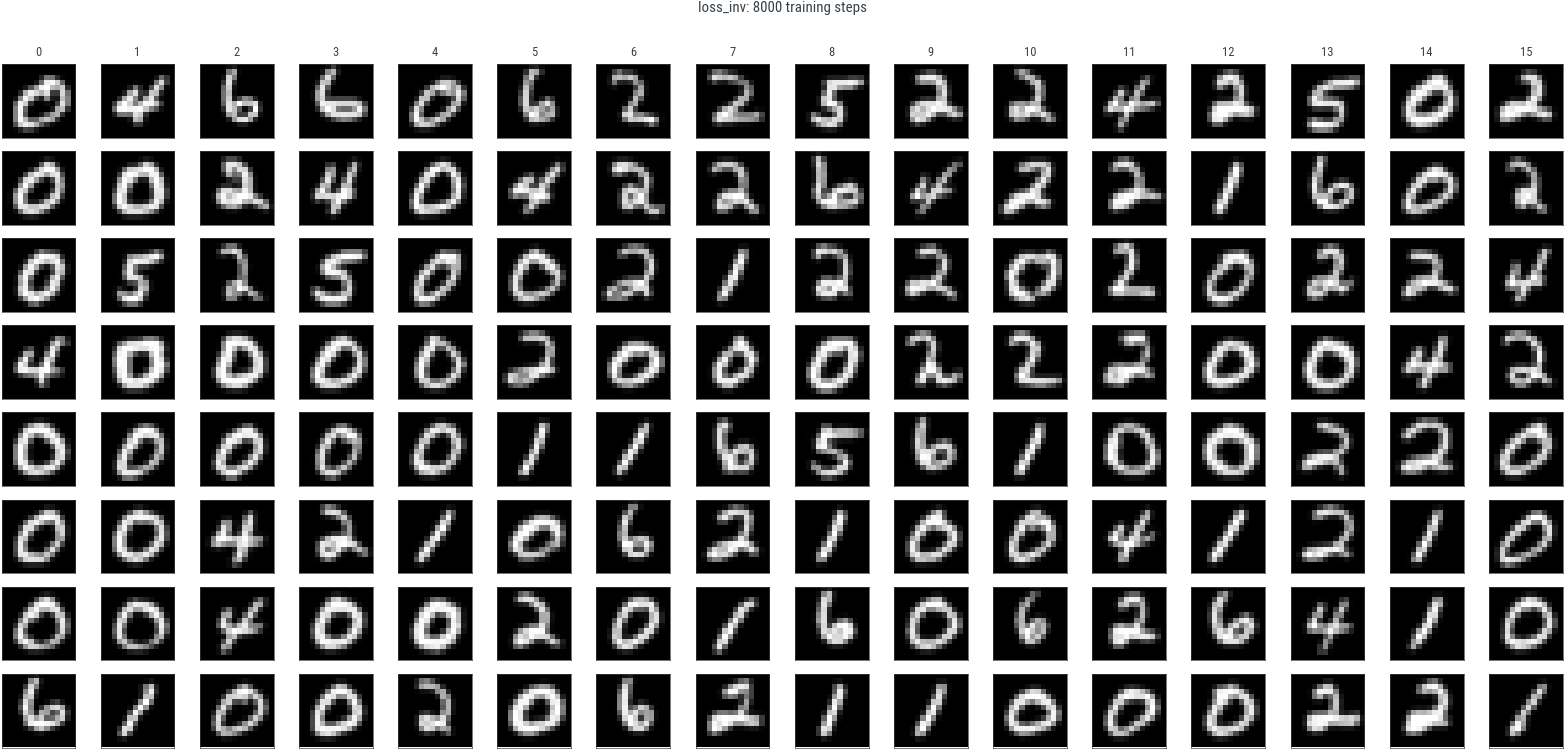

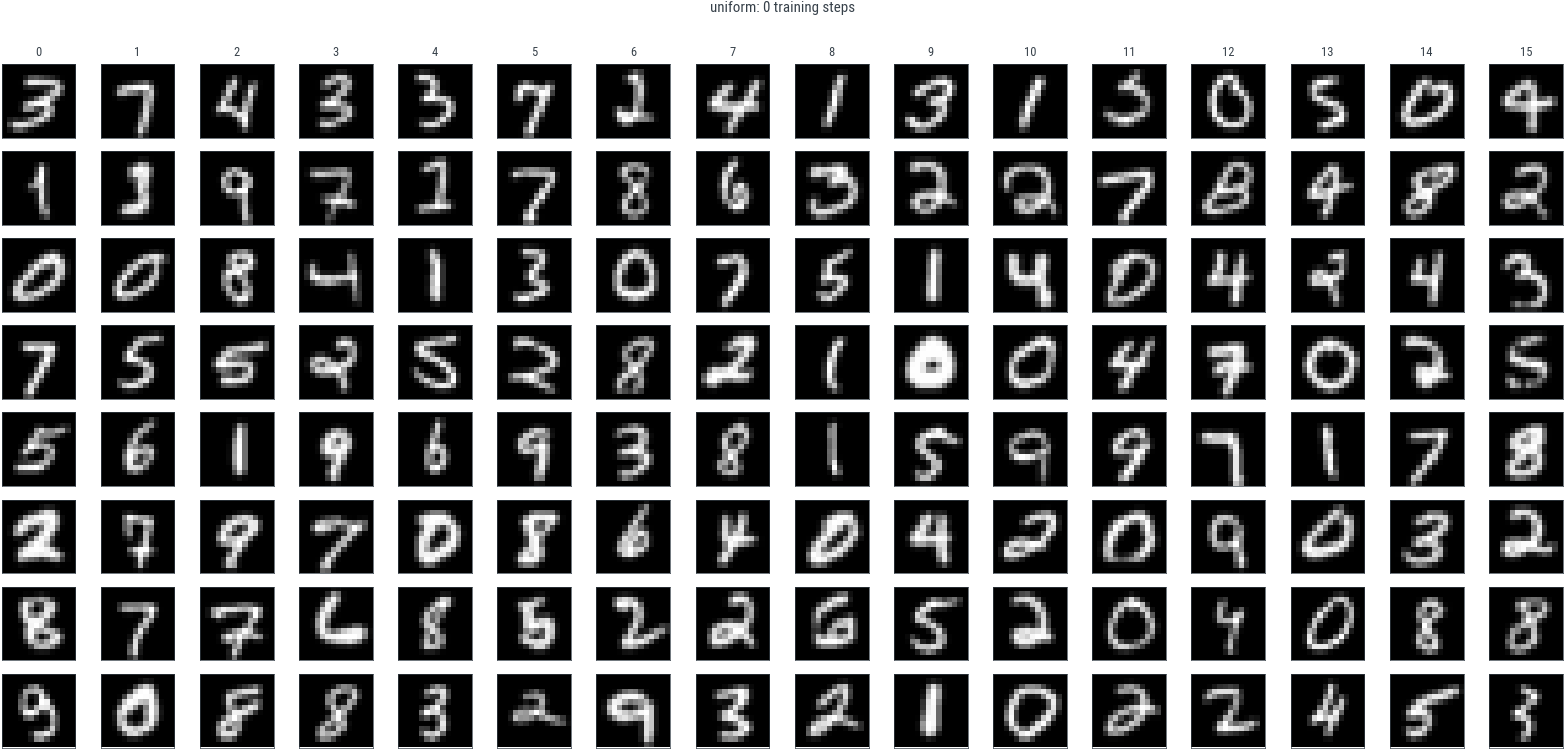

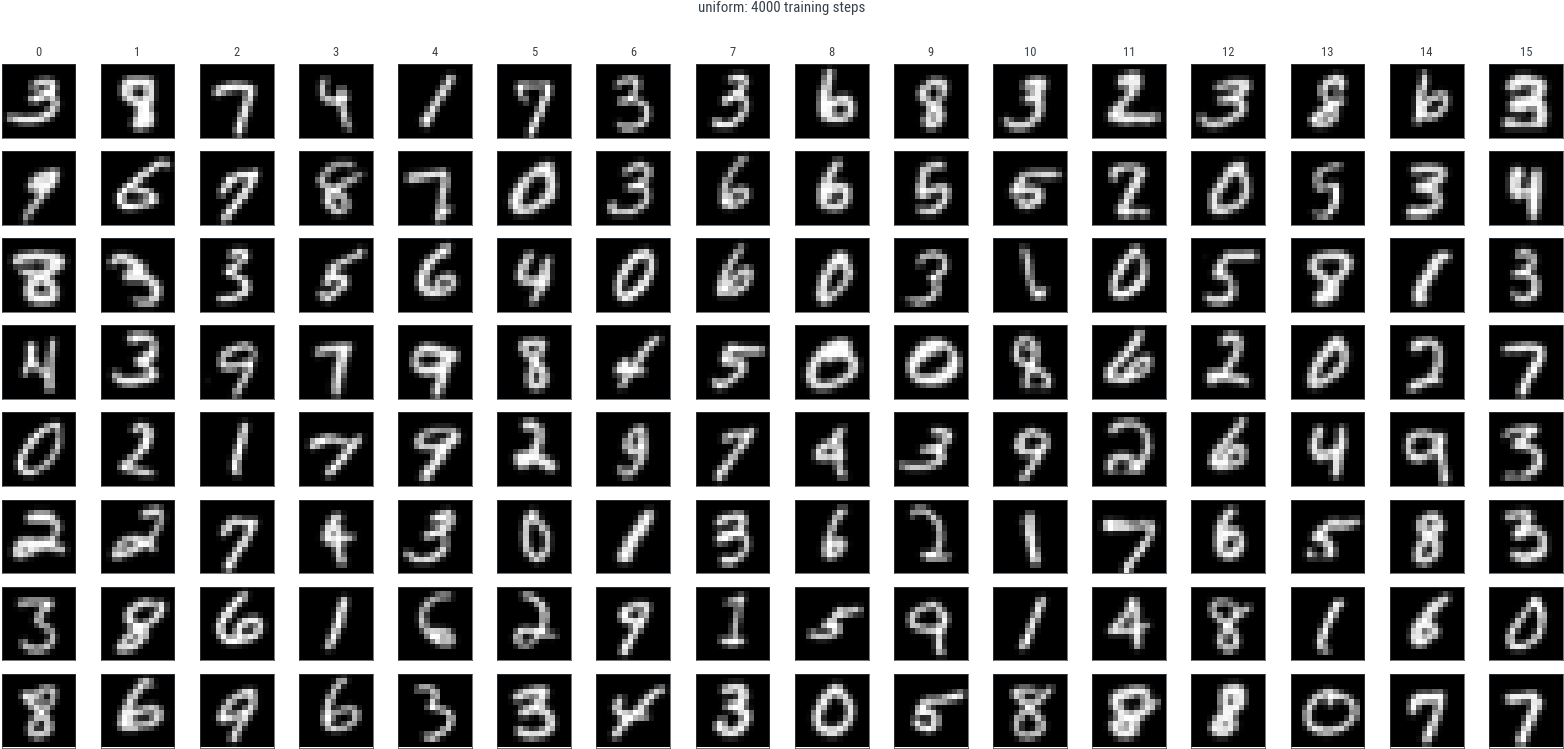

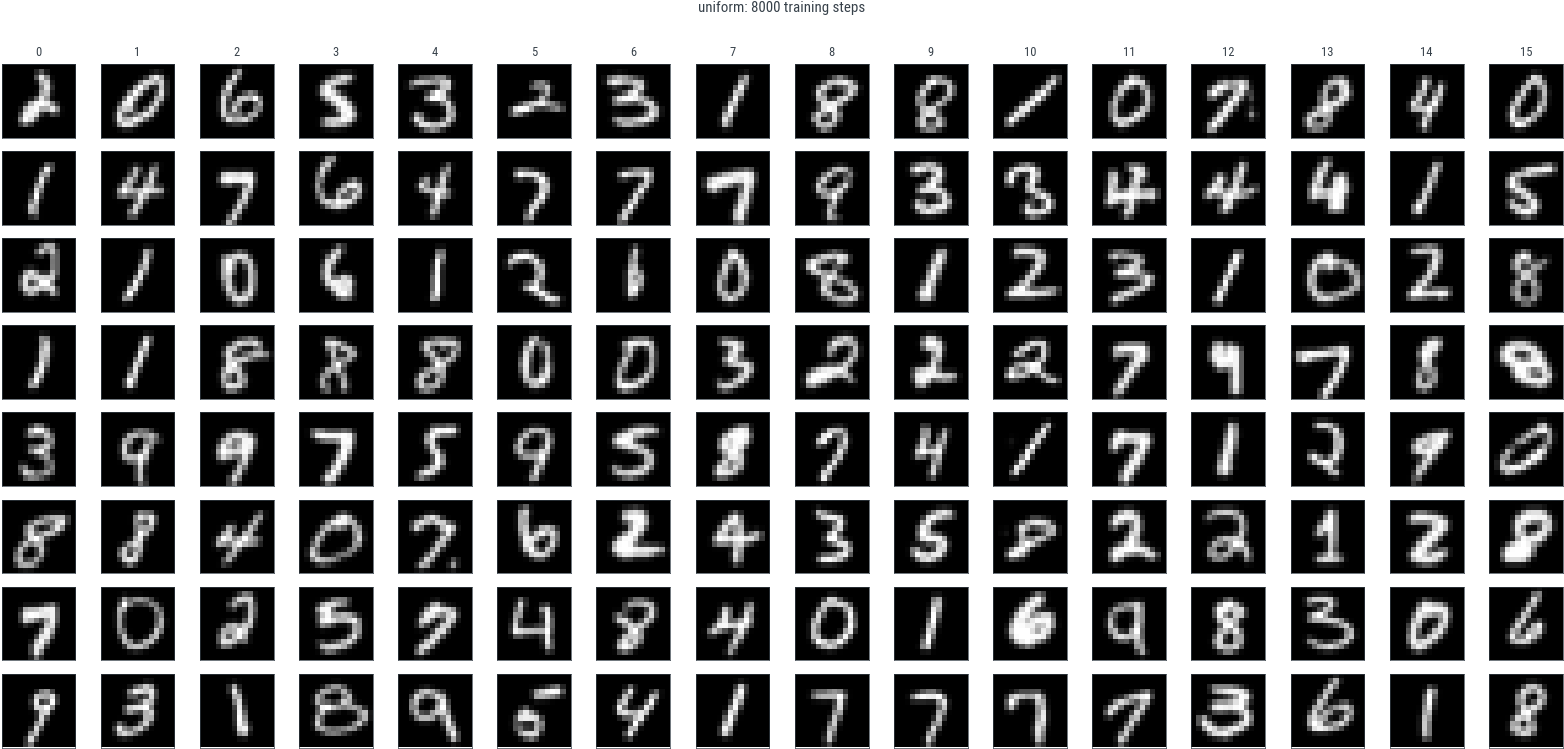

In [44]:
for sampling_method in sampling_methods:
    for step_idx, num_steps in steps.items():
        fig, axs = plt.subplots(num_samples, num_batches, figsize=(num_batches, num_samples))
        fig.suptitle(f"{sampling_method}: {num_steps} training steps")
        data = np.load(str(Path(results_path, f"{sampling_method}_{step_idx}.npy")))
        for batch_idx in range(num_batches):
            axs[0, batch_idx].set_title(f"{batch_idx}")
            for sample_idx in range(num_samples):
                axs[sample_idx, batch_idx].imshow(data[batch_idx, sample_idx].reshape(14, 14), cmap=plt.get_cmap('gray'))
                axs[sample_idx, batch_idx].set_xticks([])
                axs[sample_idx, batch_idx].set_yticks([])
        fig.tight_layout(rect=[0, 0.03, 1, 0.975])
        plt.show()

The first datapoints sampled according to the "loss-inv" strategy exhibit low class variability, as only three or four classes are represented.
Interestingly, these classes change during training.
This means that the model is, at different training stages including the initialized state, highly accurate in its predictions for very specific, varying classes.
However, as loss histograms at the different training stages show, this accurateness is not achieved for every datapoint in the mentioned classes, but only a small subset. 

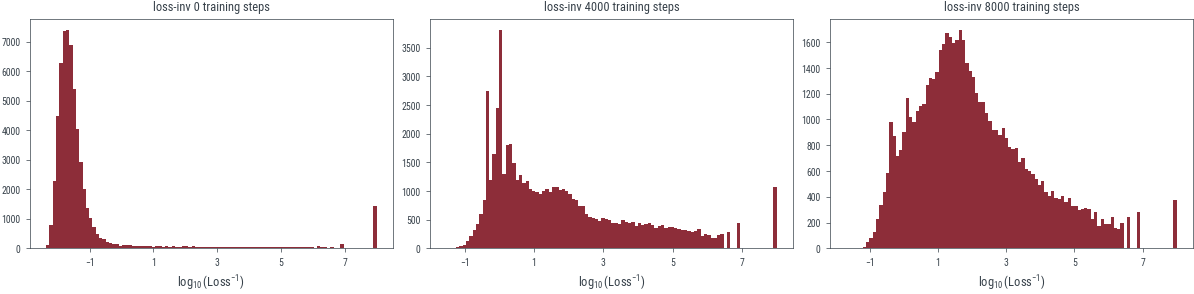

In [47]:
results_path = "../results/distr/"
steps = {0: 0, 1: 4000, 2: 8000}
num_bins = 100
log_x = True

fig, axs = plt.subplots(1, len(steps), figsize=(12, 3))

for step_idx, num_steps in steps.items():
    data = torch.load(str(Path(results_path, f"loss_inv_distr_{step_idx}.pth"))).numpy()
    hist, bins = np.histogram(data, bins=num_bins)
    if log_x:
        bins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    axs[step_idx].hist(data, bins=bins)
    xlogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[step_idx].set_title(f"loss-inv {num_steps} training steps")
    if log_x:
        axs[step_idx].set_xscale("log")
        axs[step_idx].xaxis.set_major_formatter(xlogfmt)
        axs[step_idx].set_xlabel("$\\log_{10}(\\text{Loss}^{-1})$")
    else:
        axs[step_idx].set_xlabel("$(\\text{Loss}^{-1})$")

The sampled datapoints are most likely part of the outlier bin at the very right of the histograms.
Interesingly, the fact that the loss is at 1e8 (which is the reciprocal of the epsilon that was added to the loss before inverting it to counter numerical issues) reveals that there are actually datapoints that apparently yield a zero loss.

## 2 - New Sampling Strategies:

In our meeting two weeks ago, we discussed sampling based on the gradient norm as well as class-based sampling.
Inspired from these ideas and the interesting behavior of the already tested "loss-inv" strategy, I implemented the following new sampling strategies:

- "gradnorm": Highest gradient norm -> highest probability.
- "gradnorm-inv": Lowest gradient norm -> highest probability.
- "{loss, gradnorm}-class(-inv)": 2-step sampling: First sample class according to {loss, gradnorm}(-inv) distribution over classes (taking the mean per class), then sample datapoint uniformly intra-class.
- "{loss, gradnorm}-classeq(-inv)": 2-step sampling: First sample class uniformly, then sample datapoint according to {loss, gradnorm}(-inv) distribution intra-class.

Due to the fast computation in the 14x14 MNIST setting, it was favored over the full 28x28 resolution.
While taking the last subsampled GGN as a substitute for the exact GGN was first considered as an option to reduce runtimes, tests have shown that the results are not really helpful to assess a sampling strategy, since the last subsampled GGN could still exhibit a large F-norm deviation from the exact GGN that is not visible in the plots (see below).

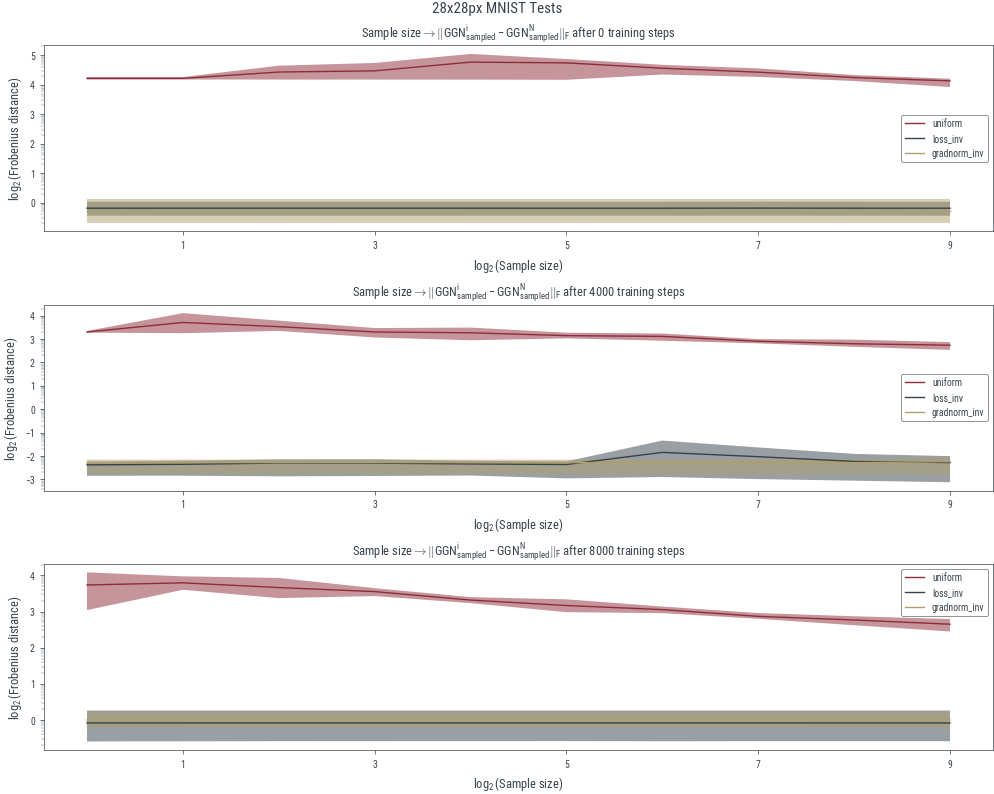

In [49]:
results_path = "../results_v4/28px_last/"
min_exp = 0
max_exp = 10
n_samples = 4
ggn_iteration_freq = 4000
num_ggn_iterations = 3
sampling_methods = ["uniform", "loss_inv", "gradnorm_inv"]

iterations = [ggn_iteration_freq * x for x in range(0, num_ggn_iterations)]
batch_sizes = [2**x for x in range(min_exp, max_exp)]

frobenius_distances = {}

for sampling_method in sampling_methods:
    frobenius_distances[sampling_method] = []
    for iters in iterations:
        frobenius_distances[sampling_method].append([])
        for batch_size in batch_sizes:
            frobenius_distances[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, f"f_norm_{batch_size}_batched_{iters}.npy"))).flatten())
        frobenius_distances[sampling_method][-1] = np.stack(frobenius_distances[sampling_method][-1])

fig, axs = plt.subplots(num_ggn_iterations, figsize=(10, 8))
fig.suptitle("28x28px MNIST Tests")

for iters_idx, iters in enumerate(iterations):
    for sampling_method in sampling_methods:
        axs[iters_idx].plot(batch_sizes, frobenius_distances[sampling_method][iters_idx].mean(axis=1), label=sampling_method.removesuffix("_total"))
        axs[iters_idx].fill_between(batch_sizes, np.min(frobenius_distances[sampling_method][iters_idx], axis=1), np.max(frobenius_distances[sampling_method][iters_idx], axis=1), alpha=0.5)
    axs[iters_idx].set_title("$\\text{Sample size} \\to \|\\text{GGN}^{i}_{\\text{sampled}} - \\text{GGN}^{N}_{\\text{sampled}}\|_F$ after " + str(iters) + " training steps")
    axs[iters_idx].set_xscale('log', base=2)
    axs[iters_idx].set_yscale('log')
    axs[iters_idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[iters_idx].xaxis.set_major_formatter(xlogfmt)
    axs[iters_idx].set_ylabel("$\\log_2{(\\text{Frobenius distance})}$")
    ylogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[iters_idx].yaxis.set_major_formatter(ylogfmt)
    axs[iters_idx].legend();

Instead, the previous configuration (see top of the document) was used again, extended by the new sampling strategies.

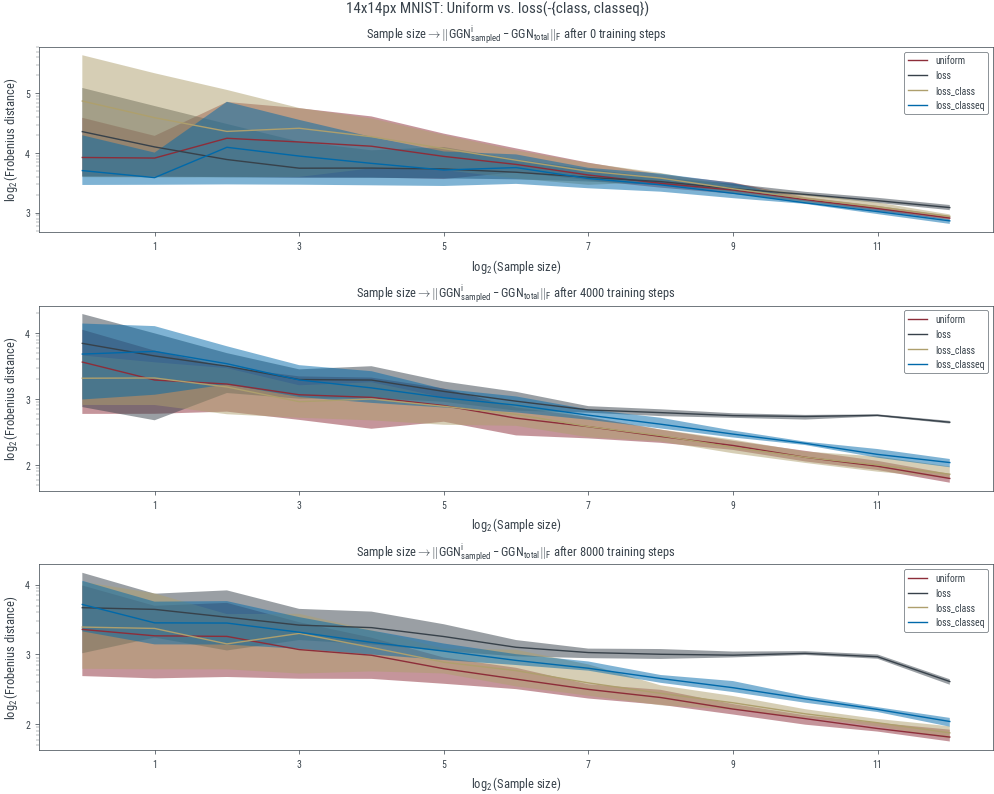

In [54]:
results_path = "../results_v4/14px_total/"
min_exp = 0
max_exp = 13
n_samples = 8
ggn_iteration_freq = 4000
num_ggn_iterations = 3

sampling_methods = ["uniform_total", "loss_total", "loss_class_total", "loss_classeq_total"]
iterations = [ggn_iteration_freq * x for x in range(0, num_ggn_iterations)]
batch_sizes = [2**x for x in range(min_exp, max_exp)]

frobenius_distances = {}

for sampling_method in sampling_methods:
    frobenius_distances[sampling_method] = []
    for iters in iterations:
        frobenius_distances[sampling_method].append([])
        for batch_size in batch_sizes:
            frobenius_distances[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, f"f_norm_{batch_size}_batched_{iters}.npy"))).flatten())
        frobenius_distances[sampling_method][-1] = np.stack(frobenius_distances[sampling_method][-1])

fig, axs = plt.subplots(num_ggn_iterations, figsize=(10, 8))
fig.suptitle("14x14px MNIST: Uniform vs. loss(-{class, classeq})")

for iters_idx, iters in enumerate(iterations):
    for sampling_method in sampling_methods:
        axs[iters_idx].plot(batch_sizes, frobenius_distances[sampling_method][iters_idx].mean(axis=1), label=sampling_method.removesuffix("_total"))
        axs[iters_idx].fill_between(batch_sizes, np.min(frobenius_distances[sampling_method][iters_idx], axis=1), np.max(frobenius_distances[sampling_method][iters_idx], axis=1), alpha=0.5)
    axs[iters_idx].set_title("$\\text{Sample size} \\to \|\\text{GGN}^{i}_{\\text{sampled}} - \\text{GGN}_{\\text{total}}\|_F$ after " + str(iters) + " training steps")
    axs[iters_idx].set_xscale('log', base=2)
    axs[iters_idx].set_yscale('log')
    axs[iters_idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[iters_idx].xaxis.set_major_formatter(xlogfmt)
    axs[iters_idx].set_ylabel("$\\log_2{(\\text{Frobenius distance})}$")
    ylogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[iters_idx].yaxis.set_major_formatter(ylogfmt)
    axs[iters_idx].legend();

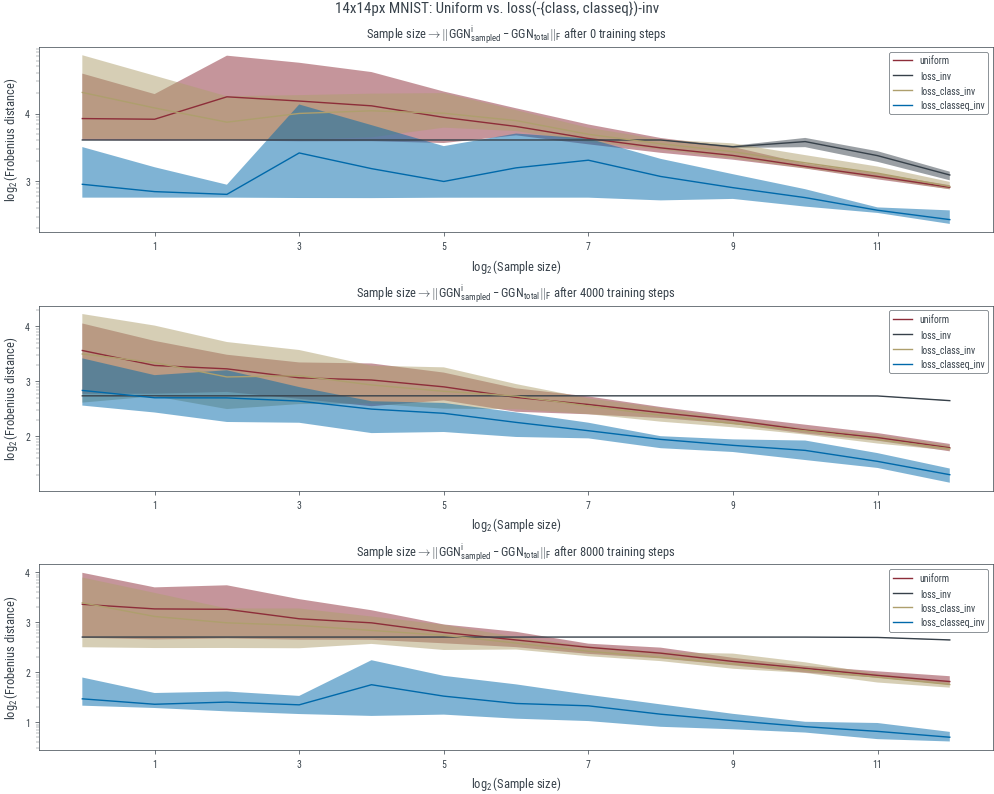

In [55]:
sampling_methods = ["uniform_total", "loss_inv_total", "loss_class_inv_total", "loss_classeq_inv_total"]
iterations = [ggn_iteration_freq * x for x in range(0, num_ggn_iterations)]
batch_sizes = [2**x for x in range(min_exp, max_exp)]

frobenius_distances = {}

for sampling_method in sampling_methods:
    frobenius_distances[sampling_method] = []
    for iters in iterations:
        frobenius_distances[sampling_method].append([])
        for batch_size in batch_sizes:
            frobenius_distances[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, f"f_norm_{batch_size}_batched_{iters}.npy"))).flatten())
        frobenius_distances[sampling_method][-1] = np.stack(frobenius_distances[sampling_method][-1])

fig, axs = plt.subplots(num_ggn_iterations, figsize=(10, 8))
fig.suptitle("14x14px MNIST: Uniform vs. loss(-{class, classeq})-inv")

for iters_idx, iters in enumerate(iterations):
    for sampling_method in sampling_methods:
        axs[iters_idx].plot(batch_sizes, frobenius_distances[sampling_method][iters_idx].mean(axis=1), label=sampling_method.removesuffix("_total"))
        axs[iters_idx].fill_between(batch_sizes, np.min(frobenius_distances[sampling_method][iters_idx], axis=1), np.max(frobenius_distances[sampling_method][iters_idx], axis=1), alpha=0.5)
    axs[iters_idx].set_title("$\\text{Sample size} \\to \|\\text{GGN}^{i}_{\\text{sampled}} - \\text{GGN}_{\\text{total}}\|_F$ after " + str(iters) + " training steps")
    axs[iters_idx].set_xscale('log', base=2)
    axs[iters_idx].set_yscale('log')
    axs[iters_idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[iters_idx].xaxis.set_major_formatter(xlogfmt)
    axs[iters_idx].set_ylabel("$\\log_2{(\\text{Frobenius distance})}$")
    ylogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[iters_idx].yaxis.set_major_formatter(ylogfmt)
    axs[iters_idx].legend();

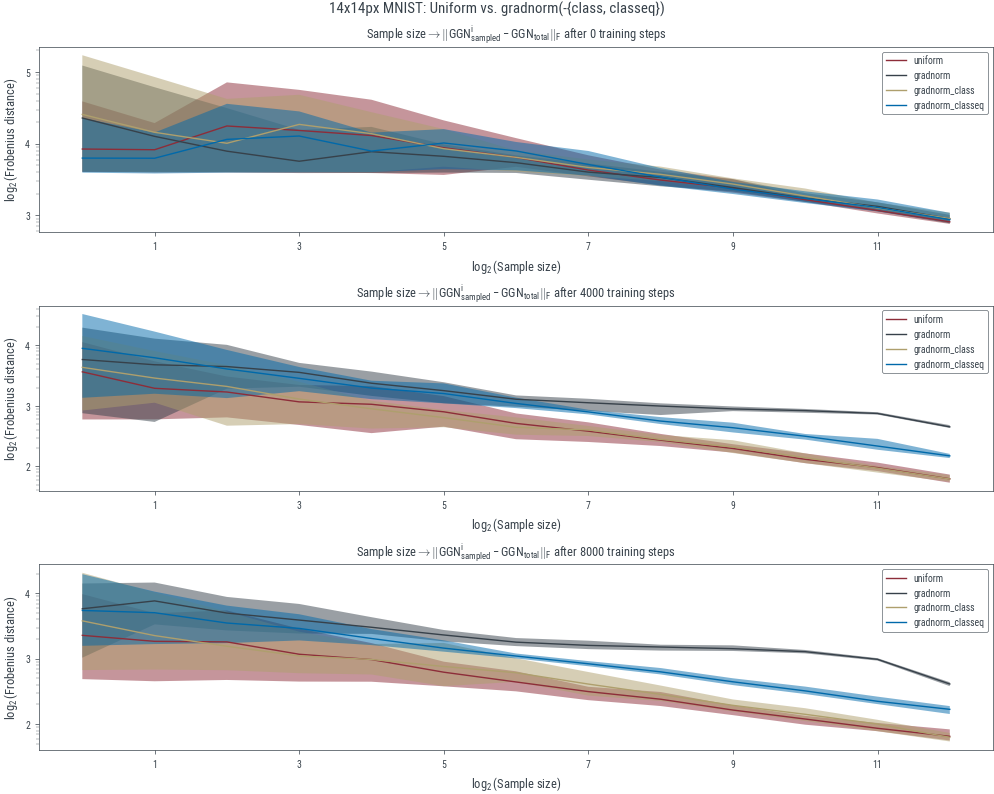

In [56]:
sampling_methods = ["uniform_total", "gradnorm_total", "gradnorm_class_total", "gradnorm_classeq_total"]
iterations = [ggn_iteration_freq * x for x in range(0, num_ggn_iterations)]
batch_sizes = [2**x for x in range(min_exp, max_exp)]

frobenius_distances = {}

for sampling_method in sampling_methods:
    frobenius_distances[sampling_method] = []
    for iters in iterations:
        frobenius_distances[sampling_method].append([])
        for batch_size in batch_sizes:
            frobenius_distances[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, f"f_norm_{batch_size}_batched_{iters}.npy"))).flatten())
        frobenius_distances[sampling_method][-1] = np.stack(frobenius_distances[sampling_method][-1])

fig, axs = plt.subplots(num_ggn_iterations, figsize=(10, 8))
fig.suptitle("14x14px MNIST: Uniform vs. gradnorm(-{class, classeq})")

for iters_idx, iters in enumerate(iterations):
    for sampling_method in sampling_methods:
        axs[iters_idx].plot(batch_sizes, frobenius_distances[sampling_method][iters_idx].mean(axis=1), label=sampling_method.removesuffix("_total"))
        axs[iters_idx].fill_between(batch_sizes, np.min(frobenius_distances[sampling_method][iters_idx], axis=1), np.max(frobenius_distances[sampling_method][iters_idx], axis=1), alpha=0.5)
    axs[iters_idx].set_title("$\\text{Sample size} \\to \|\\text{GGN}^{i}_{\\text{sampled}} - \\text{GGN}_{\\text{total}}\|_F$ after " + str(iters) + " training steps")
    axs[iters_idx].set_xscale('log', base=2)
    axs[iters_idx].set_yscale('log')
    axs[iters_idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[iters_idx].xaxis.set_major_formatter(xlogfmt)
    axs[iters_idx].set_ylabel("$\\log_2{(\\text{Frobenius distance})}$")
    ylogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[iters_idx].yaxis.set_major_formatter(ylogfmt)
    axs[iters_idx].legend();

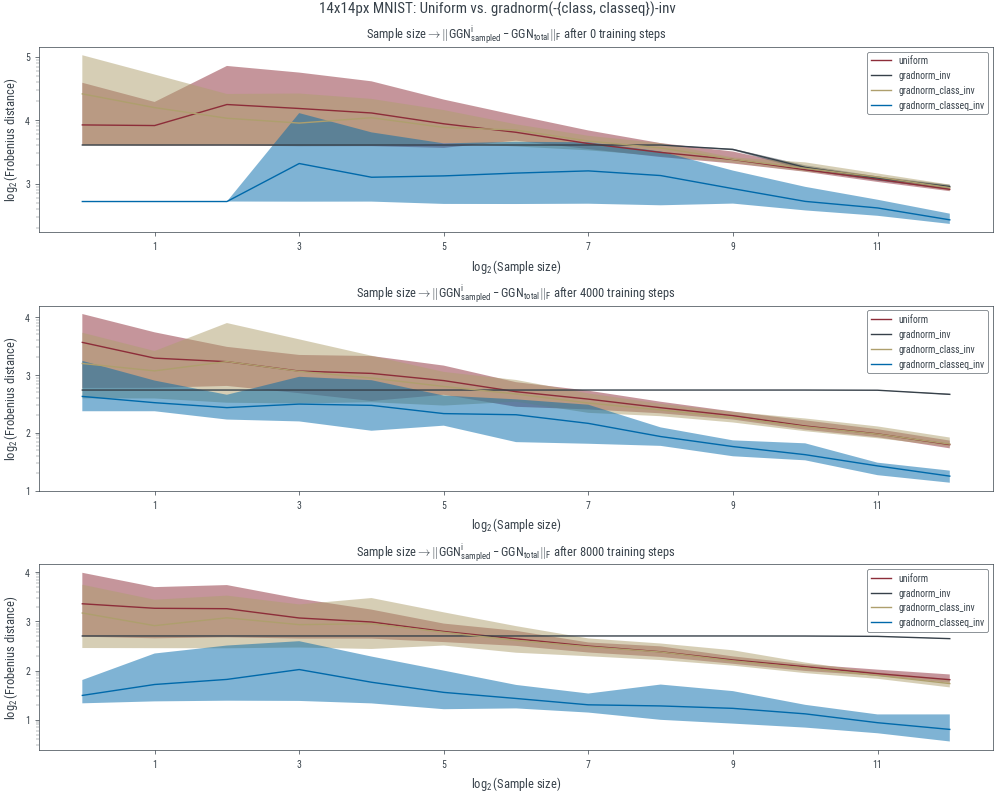

In [57]:
sampling_methods = ["uniform_total", "gradnorm_inv_total", "gradnorm_class_inv_total", "gradnorm_classeq_inv_total"]
iterations = [ggn_iteration_freq * x for x in range(0, num_ggn_iterations)]
batch_sizes = [2**x for x in range(min_exp, max_exp)]

frobenius_distances = {}

for sampling_method in sampling_methods:
    frobenius_distances[sampling_method] = []
    for iters in iterations:
        frobenius_distances[sampling_method].append([])
        for batch_size in batch_sizes:
            frobenius_distances[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, f"f_norm_{batch_size}_batched_{iters}.npy"))).flatten())
        frobenius_distances[sampling_method][-1] = np.stack(frobenius_distances[sampling_method][-1])

fig, axs = plt.subplots(num_ggn_iterations, figsize=(10, 8))
fig.suptitle("14x14px MNIST: Uniform vs. gradnorm(-{class, classeq})-inv")

for iters_idx, iters in enumerate(iterations):
    for sampling_method in sampling_methods:
        axs[iters_idx].plot(batch_sizes, frobenius_distances[sampling_method][iters_idx].mean(axis=1), label=sampling_method.removesuffix("_total"))
        axs[iters_idx].fill_between(batch_sizes, np.min(frobenius_distances[sampling_method][iters_idx], axis=1), np.max(frobenius_distances[sampling_method][iters_idx], axis=1), alpha=0.5)
    axs[iters_idx].set_title("$\\text{Sample size} \\to \|\\text{GGN}^{i}_{\\text{sampled}} - \\text{GGN}_{\\text{total}}\|_F$ after " + str(iters) + " training steps")
    axs[iters_idx].set_xscale('log', base=2)
    axs[iters_idx].set_yscale('log')
    axs[iters_idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[iters_idx].xaxis.set_major_formatter(xlogfmt)
    axs[iters_idx].set_ylabel("$\\log_2{(\\text{Frobenius distance})}$")
    ylogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[iters_idx].yaxis.set_major_formatter(ylogfmt)
    axs[iters_idx].legend();

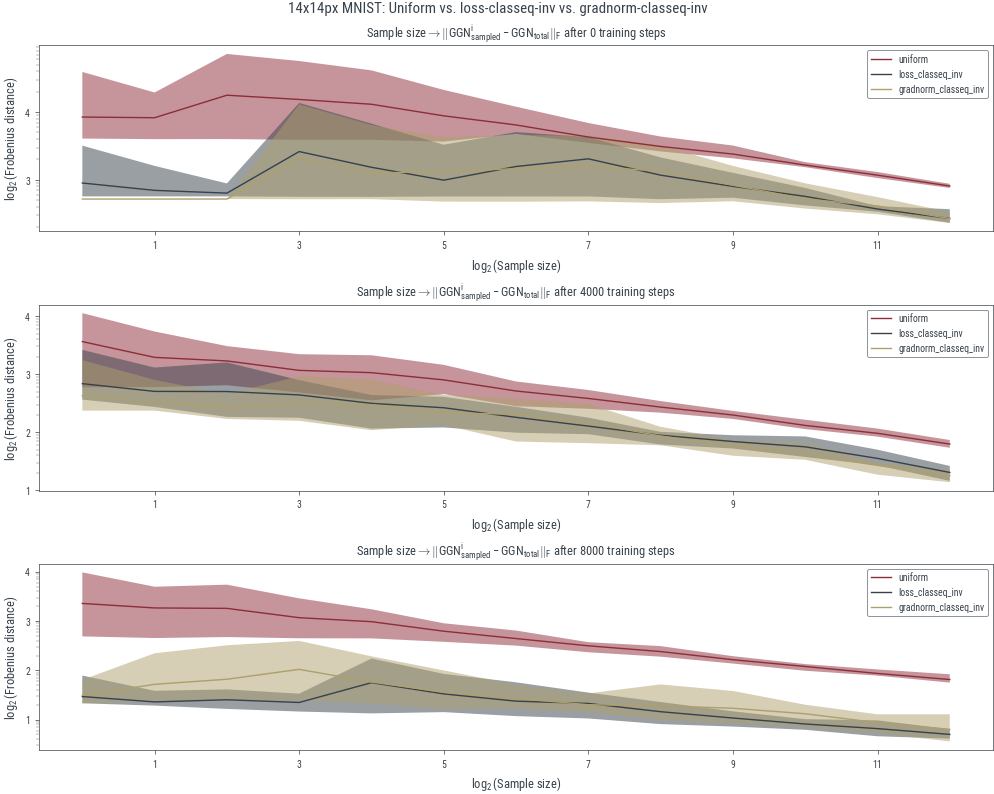

In [58]:
sampling_methods = ["uniform_total", "loss_classeq_inv_total", "gradnorm_classeq_inv_total"]
iterations = [ggn_iteration_freq * x for x in range(0, num_ggn_iterations)]
batch_sizes = [2**x for x in range(min_exp, max_exp)]

frobenius_distances = {}

for sampling_method in sampling_methods:
    frobenius_distances[sampling_method] = []
    for iters in iterations:
        frobenius_distances[sampling_method].append([])
        for batch_size in batch_sizes:
            frobenius_distances[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, f"f_norm_{batch_size}_batched_{iters}.npy"))).flatten())
        frobenius_distances[sampling_method][-1] = np.stack(frobenius_distances[sampling_method][-1])

fig, axs = plt.subplots(num_ggn_iterations, figsize=(10, 8))
fig.suptitle("14x14px MNIST: Uniform vs. loss-classeq-inv vs. gradnorm-classeq-inv")

for iters_idx, iters in enumerate(iterations):
    for sampling_method in sampling_methods:
        axs[iters_idx].plot(batch_sizes, frobenius_distances[sampling_method][iters_idx].mean(axis=1), label=sampling_method.removesuffix("_total"))
        axs[iters_idx].fill_between(batch_sizes, np.min(frobenius_distances[sampling_method][iters_idx], axis=1), np.max(frobenius_distances[sampling_method][iters_idx], axis=1), alpha=0.5)
    axs[iters_idx].set_title("$\\text{Sample size} \\to \|\\text{GGN}^{i}_{\\text{sampled}} - \\text{GGN}_{\\text{total}}\|_F$ after " + str(iters) + " training steps")
    axs[iters_idx].set_xscale('log', base=2)
    axs[iters_idx].set_yscale('log')
    axs[iters_idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[iters_idx].xaxis.set_major_formatter(xlogfmt)
    axs[iters_idx].set_ylabel("$\\log_2{(\\text{Frobenius distance})}$")
    ylogfmt = LogFormatterExponent(base=10, labelOnlyBase=True)
    axs[iters_idx].yaxis.set_major_formatter(ylogfmt)
    axs[iters_idx].legend();

From the above plots, three main conclusions can be drawn:

1. The "loss" and "gradnorm" as well as their corresponding ("-class", "-classeq", "-inv") variants yield similar results, respectively. Because the "loss" strategies are less expensive (only forward pass instead of forward + backward pass necessary), they should be preferred.
2. The "-inv" sampling strategy is superior to the corresponding regular strategy.
3. **The combination of "-inv" and "-classeq" is most effective, deceeding the F-norm error of uniform sampling for both "loss" and "gradnorm" by about one order of magnitude.**

This promising result can be made plausible as follows:

First, datapoints with high loss have large potential to be used for further optimization of the model parameters, assuming sufficient model capacity, therefore exhibiting large gradient norms and vice versa.

Second, the GGN seems to benefit most from datapoints being predicted with high accuracy or low loss, as already pointed out by previous tests with the "loss-inv" strategy (unfortunately, the reason is unknown so far). However, as the "loss-inv" strategy is only better than uniform sampling for small sample sizes, some aspect must have been missed out. Here, the observed low class variability served as a hint.

Third, solving the riddle, low-loss datapoints must also exhibit a high class variability to approximate the structure of the GGN appropriately. The proposed "loss-classeq-inv" strategy fits these needs, as it prioritizes uniform inter-class sampling and only samples according to the inverse loss intra-class.

## 3 - Next Steps:

While the presented results obtaine using the "loss-classeq-inv" strategy look very promising, some questions need to be clarified and the results have to be verified in different settings:

1. Why is the "-inv" strategy superior to the corresponding regular sampling strategy?
2. Is the Frobenius norm a good measure for the quality of GGN approximations?
3. How does the found strategy perform for different (more complex) datasets and model architectures?

The last question seems to be difficult and time-consuming to be answered, probably exceeding the scope of this research project.
Questions 1 and 2, however, might be solvable with further investigation.

To answer question 1, it could be useful to compare differently subsampled GGNs in terms of other measures, e.g., visually, by their eigenspaces, etc. Moreover, it could be worth to inspect the building blocks, the Jacobian and the Hessian, as well.

For question 2, Prof. Hennig already suggested the performance in a downstream task as a measure for comparison. Here, uncertainty quantification via Laplace approximation could serve as a rather easy-to-implement, well-understood candidate.